<a href="https://colab.research.google.com/github/krishnannarayanaswamy/GenAI-Relevance-LLM-demo/blob/main/video_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video summarization exploration

This demo explores to summarize what was happening in the short length video (less than a minute).

Existing approaches to this problem often relies only on the transcription from video.

This demo first tries to extract sampled frame images from video, and use "Image Captioning" to describe that image. Then, use OpenAI LLM to summerize the video.


In [ ]:
!pip3 install torch torchvision pyav transformers openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.3 MB/s eta 0:00:00


In [ ]:
import requests

url = "https://vod.api.video/vod/vi3EUVbGJUoTImoGwtAEk7Ov/mp4/source.mp4"
data = requests.get(url).content

with open("demo.mp4" ,mode='wb') as f:
  f.write(data)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('demo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# load video to pytorch
import torchvision

reader = torchvision.io.VideoReader("demo.mp4", "video")
reader_md = reader.get_metadata()
reader_md

{'video': {'fps': [30.0], 'duration': [10.866666666666667]},
 'audio': {'framerate': [44100.0], 'duration': [10.866009070294785]}}

In [ ]:
# Create image snapshots from video 1 second apart
import itertools

fps = reader_md["video"]["fps"][0]
duration = reader_md["video"]["duration"][0]
sampling = int(fps)
num_frames = int(fps * duration)

frames = []
for frame in reader:
  frames.append(frame)

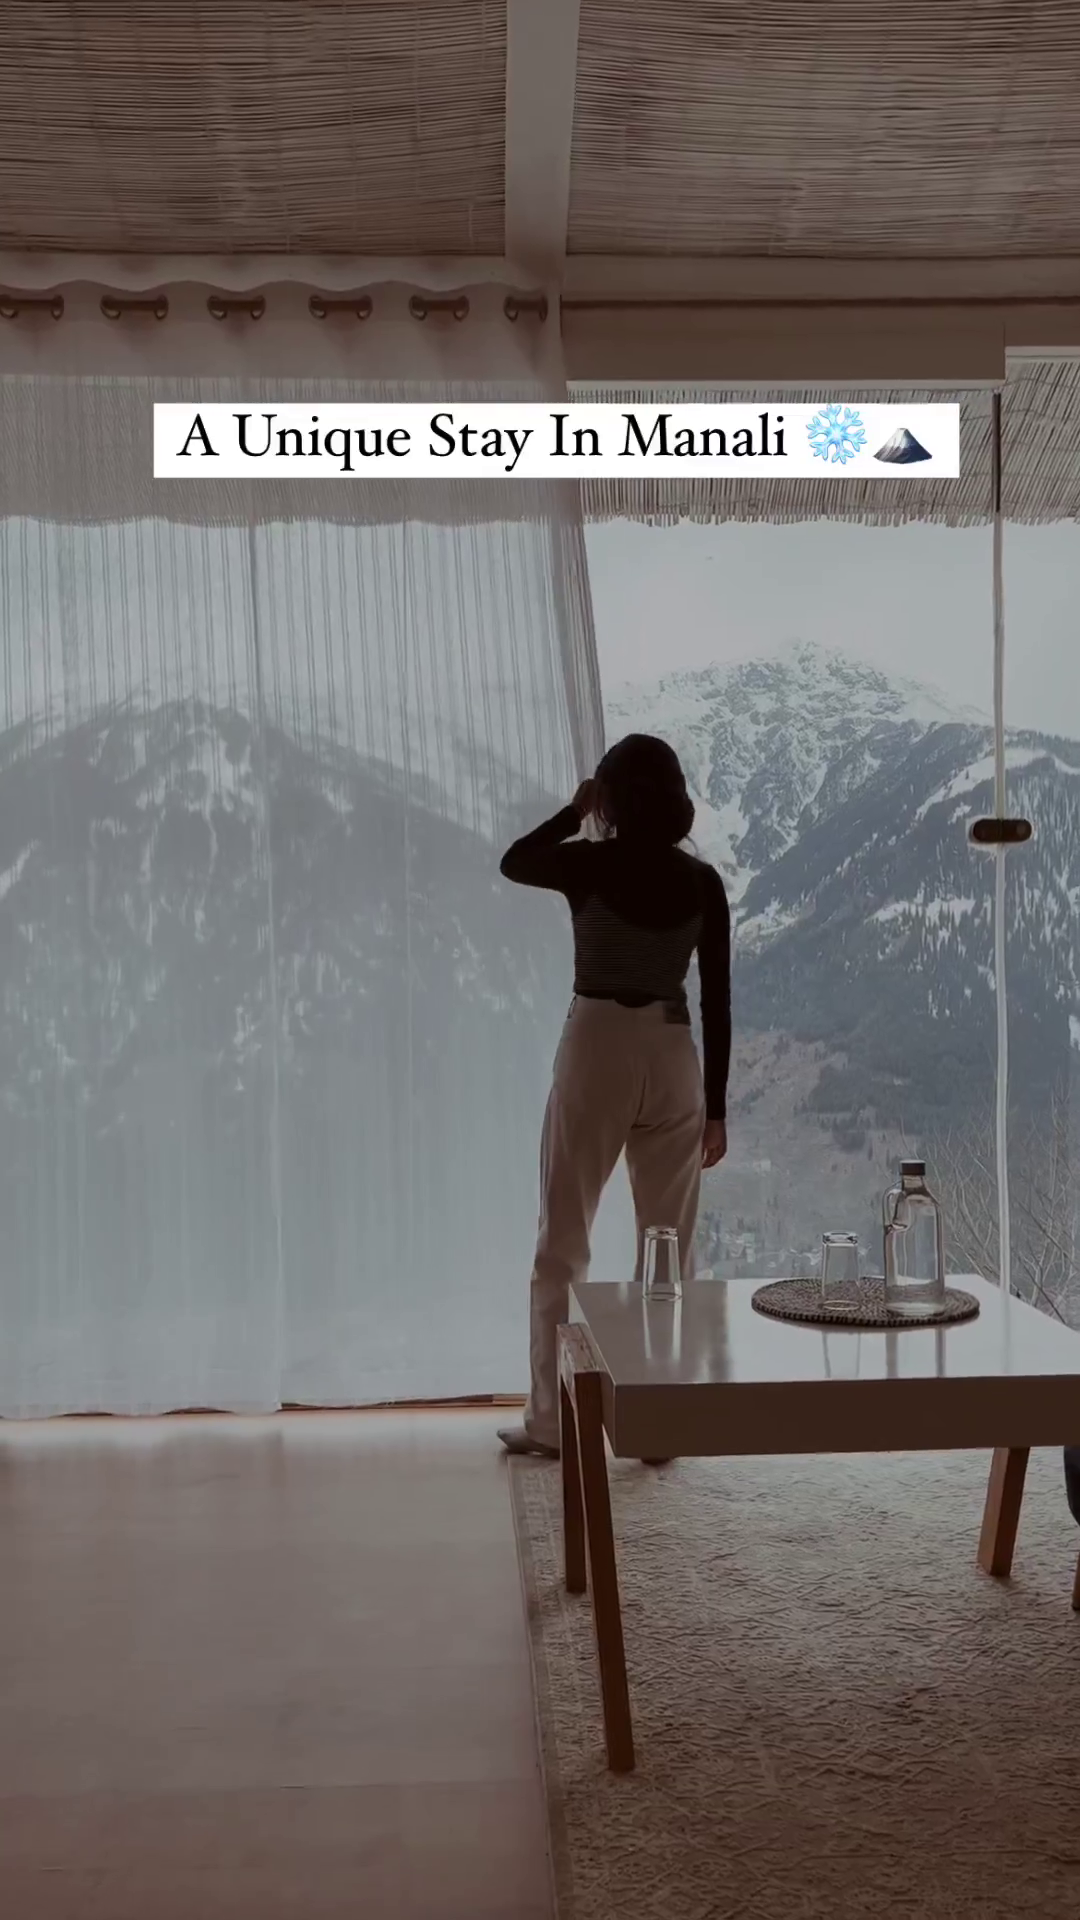

In [ ]:
from PIL import Image
toPIL = torchvision.transforms.ToPILImage()

toPIL(frames[15]["data"])

In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to("cuda")

In [ ]:
captions = []
for frame in itertools.islice(frames, 0, len(frames), sampling):
  img = toPIL(frame["data"])
  inputs = processor(img, return_tensors="pt").to("cuda", torch.float16)
  out = model.generate(**inputs)
  cap = processor.decode(out[0], skip_special_tokens=True)
  captions.append((frame["pts"], cap))
captions

[(0.0, 'there is a woman standing in a living room looking out the window'),
 (1.0, 'there is a woman standing in front of a window with a curtain'),
 (2.0, 'there is a woman standing in front of a window with a curtain'),
 (3.0,
  'there is a woman standing in front of a window looking out at the mountains'),
 (4.0, 'arafed woman standing in front of a window looking out at a mountain'),
 (5.0,
  'there is a woman standing in front of a window looking out at the mountains'),
 (6.0, 'arafed woman standing in front of a window with a mountain view'),
 (7.0,
  'there is a woman standing in front of a window looking out at the mountains'),
 (8.0, 'there is a hot tub in the snow outside of a house'),
 (9.0,
  'there is a snow covered table with a sign that says unique stay in manali'),
 (10.0, 'there is a fire pit in the middle of a patio')]

In [ ]:
import openai

openai.api_key = "OPENAI_API_KEY"

response = openai.ChatCompletion.create(
  model="gpt-4",
  messages=[
      {"role":"system", "content": "You have a task to summerize the short length video. User will ask to summarize the video from the list of descriptions. The list is created by extracting the image from sampled frame. The description has the format: (<time in second from the beginning of video>, <description of still image at that time>)."},
       {"role": "user", "content": f"Summarize the video from the following:{captions}"},
  ],
  temperature=0,
  max_tokens=1024
)

In [ ]:
response.choices[0]["message"]["content"].strip()

"The video starts with a woman standing in a living room, looking out of a window with a curtain. She seems to be admiring the mountain view outside. The scene then shifts to the exterior of the house, showcasing a hot tub in the snow. There is also a snow-covered table with a sign that reads 'Unique Stay in Manali'. The video concludes with a shot of a fire pit in the middle of a patio."